# **42577 - Project assignment**

*Authors*: s233791, s232743, s193936, s204255

*Date*: 06-11-2023

*Description*: In a world facing unprecedented challenges like climate change, pandemics, social inequality, and biodiversity decline, the need for sustainable urban mobility solutions has never been greater. This project focuses on applying data science to optimize the operations of Citi Bike, one of the largest station-based bike-sharing systems in the United States.

### The project consist of four sections:

*   Data analysis and visualization
*   Prediction Challenge
*   Exploratory Component
*   Conclusions

## Data analysis and visualization

In [2]:
# Import packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from sklearn.cluster import DBSCAN
from sklearn.metrics import pairwise_distances
import random
from matplotlib import colors as mcolors
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
%matplotlib inline

In [5]:
# We start by loading the dataset specifying the index column, and the type of each column and the datetime columns
df = pd.read_csv('    /path/to/data/Trips_2018.csv      ', index_col=0,
                 dtype={"tripduration": "int32", "start_station_id" : "category", "start_station_latitude" : "float64",
                        "start_station_longitude": "float64", "end_station_id": "category", "end_station_latitude": "float64",
                        "end_station_longitude": "float64", "bikeid": "category", "usertype": "string", "birth_year": "int64", "gender": "int64"},
                 parse_dates=["starttime", "stoptime"])

In [6]:
# We print the first 10 rows of the dataset
print(df.head(10).to_markdown(tablefmt="pipe"))

# We print the size of the dataframe
print("Dimension of dataframe: ", df.shape)

|    |   tripduration | starttime                  | stoptime                   |   start_station_id |   start_station_latitude |   start_station_longitude |   end_station_id |   end_station_latitude |   end_station_longitude |   bikeid | usertype   |   birth_year |   gender |
|---:|---------------:|:---------------------------|:---------------------------|-------------------:|-------------------------:|--------------------------:|-----------------:|-----------------------:|------------------------:|---------:|:-----------|-------------:|---------:|
|  0 |            970 | 2018-01-01 13:50:57.434000 | 2018-01-01 14:07:08.186000 |                 72 |                  40.7673 |                  -73.9939 |              505 |                40.749  |                -73.9885 |    31956 | Subscriber |         1992 |        1 |
|  1 |            723 | 2018-01-01 15:33:30.182000 | 2018-01-01 15:45:33.341000 |                 72 |                  40.7673 |                  -73.9939 |         

### Data preparation

 The data is cleaned up. This includes remove incomplete rows with missing values, identify and remove outliers. Firstly, all the datapoints with NaN values are removed.

In [7]:
# Save current shape
shape_before = df.shape

In [8]:
# We remove all data with NaN values
df.dropna(inplace=True)

# Eliminate impossible trips (<1 min; >6hrs)
df = df[(df['tripduration'] > 60) ]

# We remove users with birth year before 1918.
df = df[(df['birth_year'] > 1918)]

# We note that there are three differents types of gender. Here 0=unknown; 1=male; 2=female.
print("Gender types: ",df['gender'].unique())
print("Gender 0: ",len(df[df["gender"]==0]))
print("Gender 1: ",len(df[df["gender"]==1]))
print("Gender 2: ",len(df[df["gender"]==2]))

# We check that all starttimes are within the year 2018
print("Unique years of the starttimes: ", df['starttime'].dt.year.unique())

# Check types of users. Customer = 24-hour pass or 3-day pass user; Subscriber = Annual Member
print("Unique usertypes:", list(df['usertype'].unique()))

print(f'\nShape before cleaning data \t:\tdf.shape = {shape_before}')
print(f'Shape after cleaning data  \t:\tdf.shape = {df.shape} \n')

print(shape_before[0]-df.shape[0]," rows have been romoved. Cleaning includes removal of NaNs, birth year before 1918, impossible trips")


Gender types:  [1 0 2]
Gender 0:  1482365
Gender 1:  11960854
Gender 2:  4091343
Unique years of the starttimes:  [2018]
Unique usertypes: ['Subscriber', 'Customer']

Shape before cleaning data 	:	df.shape = (17548339, 13)
Shape after cleaning data  	:	df.shape = (17534562, 13) 

13777  rows have been romoved. Cleaning includes removal of NaNs, birth year before 1918, impossible trips


The dataset needs to be analysed for inconsistent data. Each station must have one and only one location.

In [15]:
# We start by figuring out how many unique stations are in the data set
print(df["start_station_id"].unique()) # There are 818 different station IDs

# We extract the unique location values for all the stations
uni_sta = df[['start_station_id', 'start_station_latitude', 'start_station_longitude']].drop_duplicates()

# We start by figuring out how many unique stations are in the data set
print(f"There are {uni_sta.shape[0]} unique station locations in the dataset") # One station must have two locations

# We find out which stations have multiple locations

# Group the data by 'start_station_id'
groups = df.groupby('start_station_id')

# Iterate through each group and check for inconsistencies
inconsistent_stations = []
for station_id, group in groups:
    unique_coordinates = group[['start_station_longitude', 'start_station_latitude']].drop_duplicates()
    if len(unique_coordinates) > 1:
        inconsistent_stations.append(station_id)

print("Stations with inconsistent coordinates:", inconsistent_stations)
station = df[df["start_station_id"] == "530.0"]

print(station[['start_station_longitude', 'start_station_latitude']].drop_duplicates())


coordinates_530 = df[df["start_station_id"] == "530.0"]["start_station_latitude"].unique()

print(df[(df["start_station_id"] == "530.0")&(df["start_station_latitude"] == coordinates_530[0])].shape)
print(df[(df["start_station_id"] == "530.0")&(df["start_station_latitude"] == coordinates_530[1])].shape)

'''
After research, it has been discovered that (-73.990541, 40.771522) and
(-73.990460, 40.771497) are almost identical. To correct this error in the dataset
the station_id must have one and only one set of coordinates. Since there are more
trips, which starts from (-73.990541, 40.771522) than (-73.990460, 40.771497),
we choose the first set of coordinates to be the actual ones. Therefore we have to
correct (-73.990460, 40.771497) -> (-73.990541, 40.771522) for all trips (both
as start and stop).
'''

['72.0', '79.0', '82.0', '83.0', '119.0', ..., '3716.0', '3718.0', '3719.0', '3721.0', '3720.0']
Length: 818
Categories (818, object): ['119.0', '120.0', '127.0', '128.0', ..., '3718.0', '3719.0', '3720.0',
                           '3721.0']
There are 819 unique station locations in the dataset
Stations with inconsistent coordinates: ['530.0']
          start_station_longitude  start_station_latitude
425248                 -73.990541               40.771522
16532140               -73.990460               40.771497
(42891, 13)
(2542, 13)


'\nAfter research, it has been discovered that (-73.990541, 40.771522) and \n(-73.990460, 40.771497) are almost identical. To correct this error in the dataset\nthe station_id must have one and only one set of coordinates. Since there are more \ntrips, which starts from (-73.990541, 40.771522) than (-73.990460, 40.771497),\nwe choose the first set of coordinates to be the actual ones. Therefore we have to\ncorrect (-73.990460, 40.771497) -> (-73.990541, 40.771522) for all trips (both \nas start and stop).\n'

(40.64653836709648, 46.506364054011385)

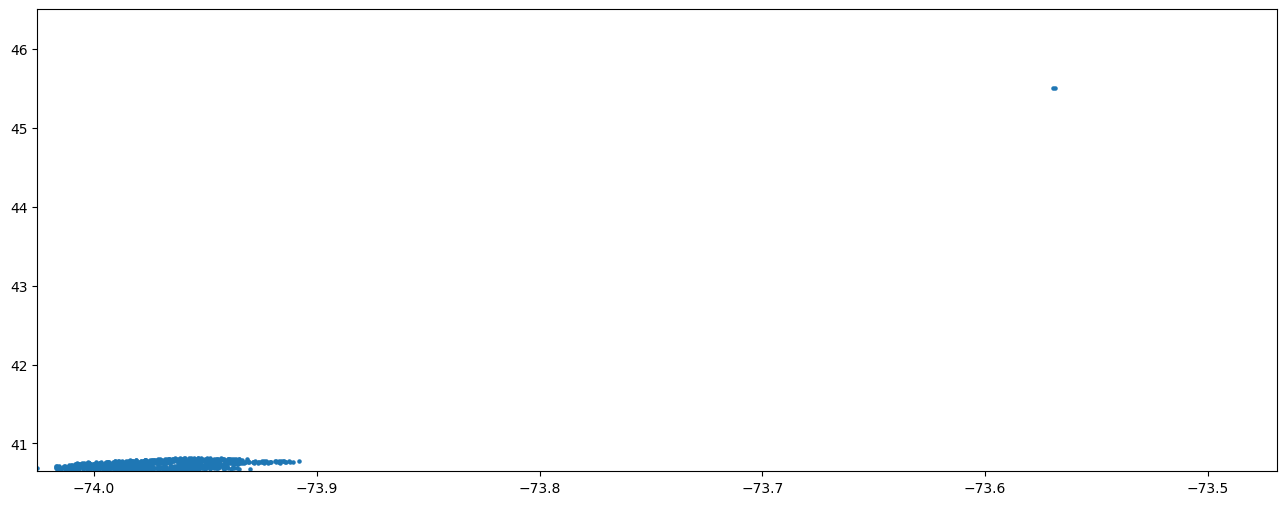

In [ ]:
# We start by plotting the data
plt.figure(figsize=(16, 6))
plt.scatter(uni_sta['start_station_longitude'], uni_sta['start_station_latitude'], s=5)

plt.xlim((min(uni_sta['start_station_longitude']), max(uni_sta['start_station_longitude'])+0.1))
plt.ylim((min(uni_sta['start_station_latitude']), max(uni_sta['start_station_latitude'])+1))

['3488.0', '3650.0']
Categories (818, object): ['119.0', '120.0', '127.0', '128.0', ..., '3718.0', '3719.0', '3720.0',
                           '3721.0']
0.00043% of the rows have start_station_id equal to 3488 or 3650.


(40.636538367096485, 40.82439443791581)

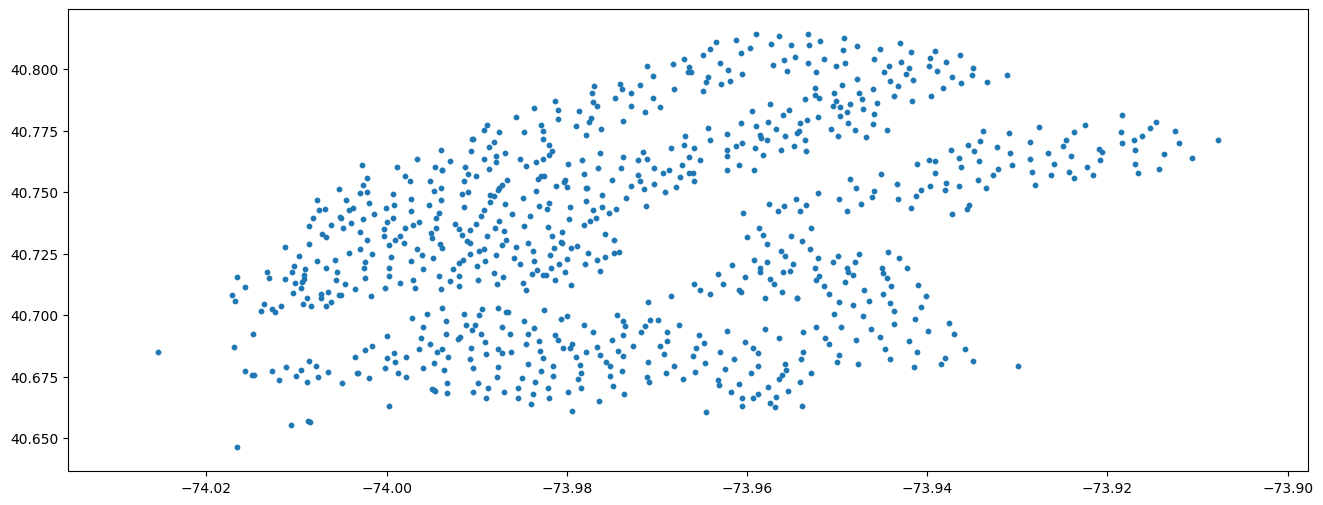

In [ ]:
# We see from the plot that there are few stations that lie far away from the rest. We find out what stations it is
df_outlier = uni_sta[uni_sta["start_station_longitude"] > -73.7]
print(df_outlier["start_station_id"].unique()) # there are two such stations with ID 3488 and 3650

# Check how many percent of the total rides are made up for by these two station
filtered_rows = df[(df['start_station_id'] == "3488.0") | (df['start_station_id'] == "3650.0")]
percentage = (len(filtered_rows) / len(df)) * 100
print(f"{percentage:.5f}% of the rows have start_station_id equal to 3488 or 3650.") # only

# Since they only make up 0.00043% of the trips, we decide to remove them from the dataset
uni_sta_excl = uni_sta[(uni_sta["start_station_longitude"] < -73.7)]

# We plot the stations again
plt.figure(figsize=(16, 6))
plt.scatter(uni_sta_excl['start_station_longitude'], uni_sta_excl['start_station_latitude'], s=10)

plt.xlim((min(uni_sta_excl['start_station_longitude']) - 0.01, max(uni_sta_excl['start_station_longitude']) + 0.01))
plt.ylim((min(uni_sta_excl['start_station_latitude']) -0.01 , max(uni_sta_excl['start_station_latitude']) + 0.01))


Now we want to cluster the stations specially using either density-based clustering or K-means clustering. To evaluate the clustering performance of each method with different parameters, we use the distrotion measure.

In [ ]:
# Code to check best combination for dbscan that gives the best distortion value

def test_dbscan(data, min_clusters, max_clusters, min_samples, max_samples, eps_min, eps_max, eps_step):
  # Here we test the dbscan algorithm
  best_eps = None
  best_min_samples = None
  best_distortion = float('inf')

  # Define the range of min_samples and eps values to search
  min_samples_range = range(min_samples, max_samples)  # Adjust as needed
  eps_range = np.arange(eps_min, eps_max, eps_step)  # Adjust as needed

  for min_samples in min_samples_range:
    for eps in eps_range:
      dbscan = DBSCAN(eps=eps, min_samples=min_samples)
      cluster_labels = dbscan.fit_predict(x)
      num_clusters = len(set(cluster_labels)) - 1  # Exclude noise (-1 label)

      if num_clusters >= min_clusters and num_clusters <= max_clusters:
          cluster_centers = [x[cluster_labels == i].mean(axis=0) for i in range(num_clusters)]
          distances = pairwise_distances(x, cluster_centers)
          distortion = sum(distances.min(axis=1))

          if distortion < best_distortion:
              best_distortion = distortion
              best_eps = eps
              best_min_samples = min_samples

  print("Best min_samples:", best_min_samples)
  print("Best eps:", best_eps)
  print("Best Distortion:", best_distortion)

x=uni_sta_excl[['start_station_longitude', 'start_station_latitude']]
test_dbscan(x, 20, 30, 1, 50, 0.001, 0.05, 0.001)

Best min_samples: 6
Best eps: 0.004
Best Distortion: 6.866704156518974


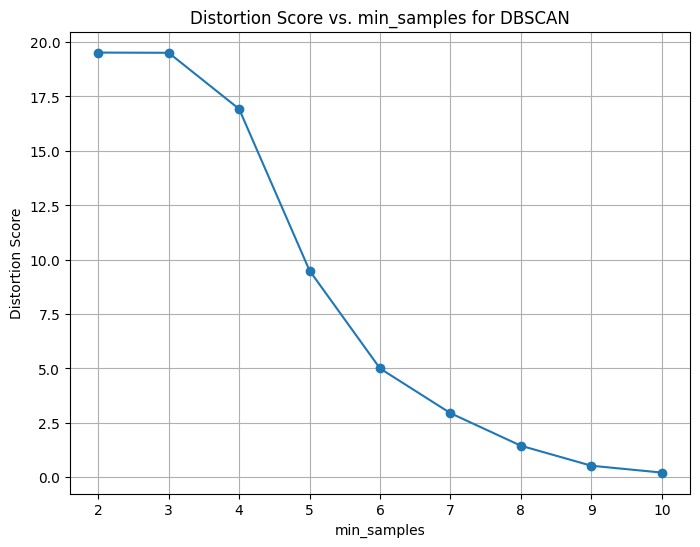

In [ ]:
# Code to make plot over min_sample based on fixed eps

def plot_min_sample_distortion(data, sample_min, sample_max, eps_value):
  # Define a range of min_samples values to test
  min_samples_range = range(sample_min,sample_max)

  # Lists to store Distortion Scores for each min_samples value
  distortion_scores = []

  for min_samples in min_samples_range:
      # Create and fit the DBSCAN model with the current min_samples value
      dbscan = DBSCAN(eps=eps_value, min_samples=min_samples)
      cluster_labels = dbscan.fit_predict(data)

      # Calculate cluster centers
      cluster_centers = [data[cluster_labels == i].mean(axis=0) for i in range(len(set(cluster_labels)) - 1)]

      # Calculate the pairwise distances
      distances = sum([sum(np.linalg.norm(data[cluster_labels == i] - center, axis=1)) for i, center in enumerate(cluster_centers)])

      # Calculate the Distortion Score and store it
      distortion_scores.append(distances)

  # Plot the Distortion Scores vs. min_samples
  plt.figure(figsize=(8, 6))
  plt.plot(min_samples_range, distortion_scores, marker='o')
  plt.title('Distortion Score vs. min_samples for DBSCAN')
  plt.xlabel('min_samples')
  plt.ylabel('Distortion Score')
  plt.grid(True)
  plt.show()

plot_min_sample_distortion(x, 2, 11, 0.004)


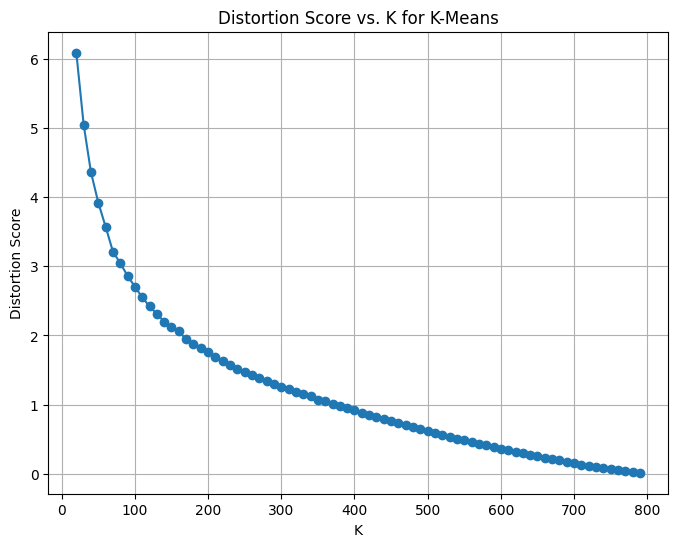

In [ ]:
def plot_k_distortion(data, k_min, k_max, step):
  # Define a range of min_samples values to test
  k_range = range(k_min, k_max, step)

  # Lists to store Distortion Scores for each min_samples value
  distortion_scores = []

  for k in k_range:
      # Create and fit the DBSCAN model with the current min_samples value
      kmeans = KMeans(k, n_init = 10)
      cluster_labels = kmeans.fit_predict(data)

      # Calculate cluster centers
      cluster_centers = [data[cluster_labels == i].mean(axis=0) for i in range(len(set(cluster_labels)) - 1)]

      # Calculate the pairwise distances
      distances = sum([sum(np.linalg.norm(data[cluster_labels == i] - center, axis=1)) for i, center in enumerate(cluster_centers)])

      # Calculate the Distortion Score and store it
      distortion_scores.append(distances)

  # Plot the Distortion Scores vs. min_samples
  plt.figure(figsize=(8, 6))
  plt.plot(k_range, distortion_scores, marker='o')
  plt.title('Distortion Score vs. K for K-Means')
  plt.xlabel('K')
  plt.ylabel('Distortion Score')
  plt.grid(True)
  plt.show()
  del kmeans

plot_k_distortion(x, 20, 800, 10)



This is here we write why we use the density-based clustering. We want over 20 clusters and we want a distortion score of less than 6.87 to use K-means rather than dbscan.

In [ ]:

# We now try to cluster the data using DBScan

# We create the DBScan instance
dbs=DBSCAN(min_samples=6, eps=0.004)

# We fit the model
x=uni_sta_excl[['start_station_longitude', 'start_station_latitude']]
dbs.fit(x)

"""
kmeans = KMeans(20)
kmeans.fit(x)
"""

'\nkmeans = KMeans(20)\nkmeans.fit(x)\n'

28 clusters were identified


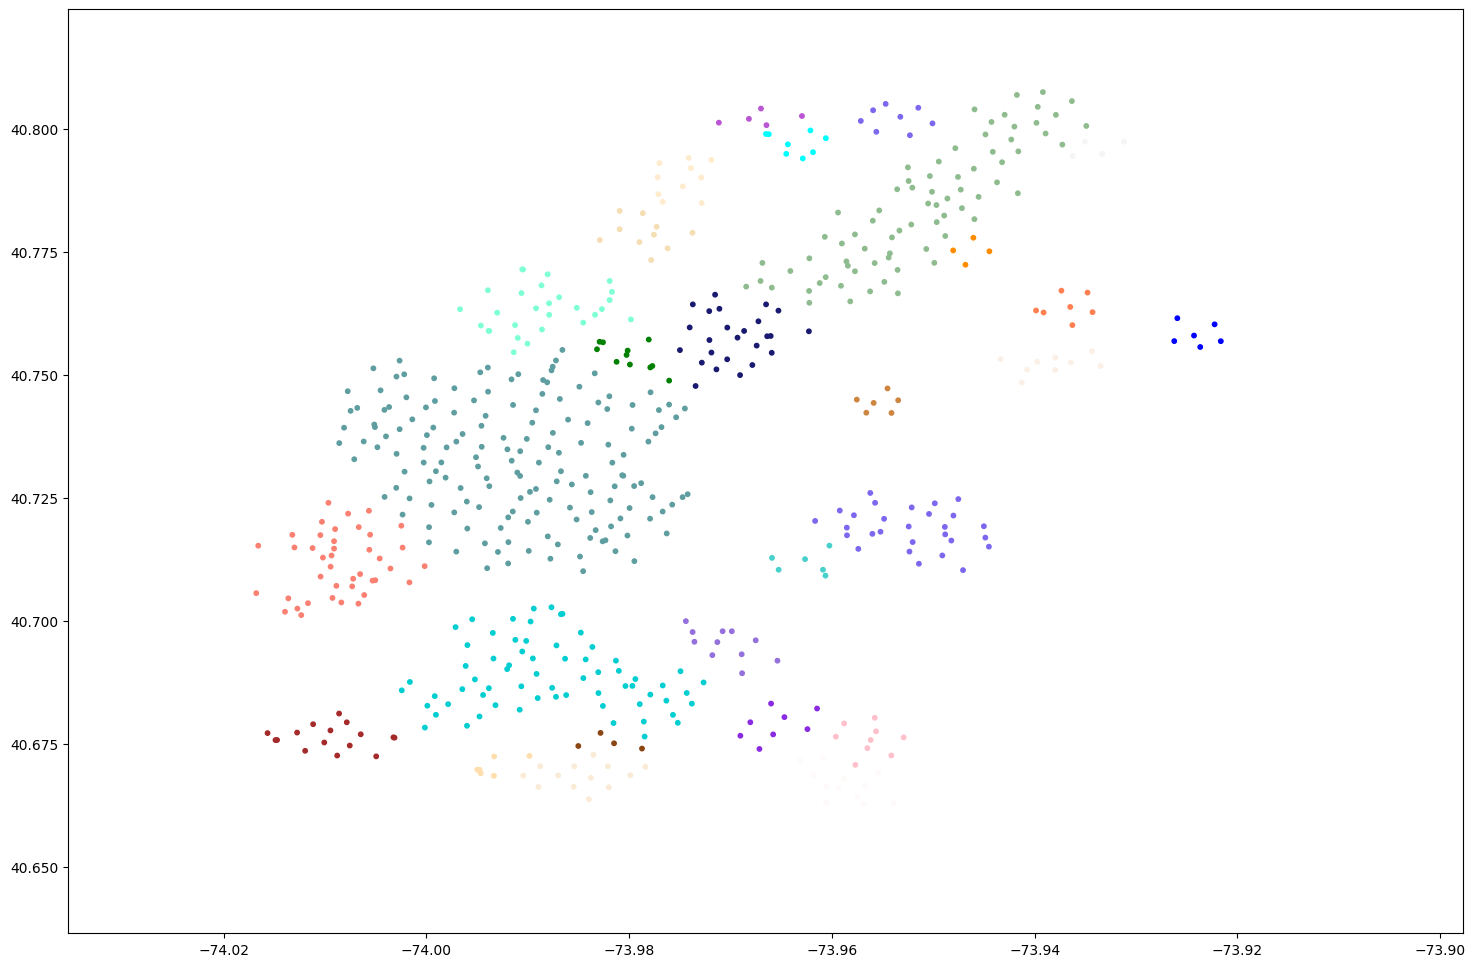

In [ ]:
def plot_clusters(model, data):
  num_colors=len(set(model.labels_))
  colors=list(mcolors.CSS4_COLORS.keys())  #found this by searching "python color list"
  cluster_colors=random.choices(colors, k=num_colors)

  x_=[]
  y_=[]
  c_=[]
  for label, x, y  in zip(model.labels_, data['start_station_longitude'], data['start_station_latitude']):
      if label!=-1:
          x_.append(x)
          y_.append(y)
          c_.append(cluster_colors[label])
  plt.figure(figsize=(18, 12))
  plt.scatter(x_,y_,s=10,c=c_)

  # Setting the same axis, just for reading the results
  plt.xlim((min(data['start_station_longitude']) - 0.01, max(data['start_station_longitude']) + 0.01))
  plt.ylim((min(data['start_station_latitude']) - 0.01, max(data['start_station_latitude']) + 0.01))

  num_clusters = len(set(model.labels_)) - (1 if -1 in model.labels_ else 0)
  print(f"{num_clusters} clusters were identified")

x=uni_sta_excl[['start_station_longitude', 'start_station_latitude']]
plot_clusters(dbs, x)
#plot_clusters(kmeans, x)


The following sections is dedicated to predicting the demand of bysicle rides over a periode of 24h. Therefore, the clusteres are sorted by size with the function below.

In [ ]:
def get_cluster_labels(df, model, start_station = True, chunk_size=20000):
  cluster_labels_start = []
  cluster_labels_end = []
  num_rows = len(df)
  for start in range(0, num_rows, chunk_size):
    end = min(start + chunk_size, num_rows)
    chunk = df.iloc[start:end]
    labels_start = model.fit_predict(chunk[['start_station_longitude', 'start_station_latitude']])
    labels_end = model.fit_predict(chunk[['end_station_longitude', 'end_station_latitude']])
    cluster_labels_start.extend(labels_start)
    cluster_labels_end.extend(labels_end)
  return cluster_labels_start, cluster_labels_end

labels_start, labels_end = get_cluster_labels(df, dbs)
del dbs
df["start_at_cluster"] = labels_start
df["end_at_cluster"] = labels_end

#cluster_counts_end = df['end_at_cluster'].value_counts()

#print(cluster_counts_end)

"""
cluster_lab = kmeans.fit_predict(df[['start_station_longitude', 'start_station_latitude']])
df['belong_to_cluster'] = cluster_lab
df.head()
cluster_counts = df['belong_to_cluster'].value_counts()
"""


"\ncluster_lab = kmeans.fit_predict(df[['start_station_longitude', 'start_station_latitude']])\ndf['belong_to_cluster'] = cluster_lab\ndf.head()\ncluster_counts = df['belong_to_cluster'].value_counts()\n"

In [ ]:
cluster_counts_start = df['start_at_cluster'].value_counts()
print(cluster_counts_start)

 0     6502247
 1     3607155
 2     2071640
 3     1464741
 4     1098008
 5      791449
 6      559701
 7      374393
 8      272793
 9      225624
 10     132221
 11     114879
 12      87401
 13      49429
 14      41816
 15      26664
 17      23352
 16      21770
 20      15401
 18      11130
-1        9163
 19       8209
 22       4667
 21       4195
 31       2984
 23       2884
 24       1858
 25       1440
 34       1377
 26       1281
 30        883
 27        584
 28        408
 29        344
 32        245
 33        214
Name: start_at_cluster, dtype: int64


The clustering returns 33 clusters where 9163 stations are not in any cluster. The biggest cluster contains 6502247 stations. This is the cluster that is used for the prediction of ride demands.

In [ ]:
# We save the dataframe with the cluster labels, so we do not have to run our code again every time
df.to_csv('data_with_clusters.csv', index=False)

In [ ]:
# Import the data_with_clusters.csv file
#df = pd.read_csv("data_with_clusters.csv")

ParserError: ignored

In [ ]:
# Extract just the data from the first cluster
df_c_1 = df.loc[(df["start_at_cluster"] == 0)].copy()

In [ ]:


def get_hourly_rides(df_in):
  date_range = pd.date_range(start='2018-01-01 00:00:00', end='2018-12-31 23:00:00', freq='H')
  df_out = pd.DataFrame({'datetime': date_range})
  rides_per_hour = df_in.groupby(df_in['starttime'].dt.floor('H')).size().reset_index(name='ride_count')
  rides_per_hour['ride_count'] = rides_per_hour['ride_count'].astype(int)
  df_out = df_out.merge(rides_per_hour, how='left', left_on='datetime', right_on='starttime')[['datetime', 'ride_count']]
  df_out['ride_count'] = df_out['ride_count'].fillna(0)
  return df_out

df_c_1_h = get_hourly_rides(df_c_1)

In [ ]:
df_c_1_h.set_index('datetime', inplace=True)
reshaped_df = df_c_1_h.pivot_table(index=df_c_1_h.index.date, columns=df_c_1_h.index.hour, values='ride_count')
reshaped_df.reset_index(inplace=True)
reshaped_df.columns = ['date'] + [f'hour_{hour}' for hour in range(1, 25)]

In [ ]:
reshaped_df.set_index('date', inplace=True)
reshaped_df.index = pd.to_datetime(reshaped_df.index)

In [ ]:
reshaped_df.head()

,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,...,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,hour_24
date,,,,,,,,,,,,,,,,,,,,,
2018-01-01,11.0,6.0,9.0,2.0,3.0,2.0,3.0,5.0,8.0,16.0,...,39.0,36.0,38.0,30.0,34.0,22.0,20.0,14.0,12.0,6.0
2018-01-02,3.0,1.0,2.0,0.0,4.0,18.0,52.0,106.0,139.0,87.0,...,79.0,74.0,107.0,141.0,139.0,92.0,74.0,33.0,24.0,12.0
2018-01-03,3.0,3.0,6.0,4.0,11.0,17.0,81.0,139.0,228.0,137.0,...,112.0,87.0,142.0,191.0,212.0,136.0,105.0,60.0,51.0,15.0
2018-01-04,8.0,8.0,2.0,1.0,5.0,11.0,18.0,17.0,24.0,17.0,...,2.0,2.0,8.0,9.0,12.0,2.0,14.0,6.0,8.0,6.0
2018-01-05,2.0,1.0,1.0,1.0,1.0,3.0,8.0,25.0,48.0,41.0,...,21.0,30.0,31.0,36.0,34.0,27.0,13.0,10.0,7.0,6.0


In [ ]:
def next_day_of_week(current_day):
    # Define a list of days of the week
    days_of_week = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
    # Calculate the next day by adding 1 and wrapping around to 0 for Sunday
    next_day_index = (current_day + 1) % 7
    # Return the next day
    return days_of_week[next_day_index]

def is_next_day_weekend(day_number):
    return 1 if (day_number + 1) % 7 in {5, 6} else 0

def get_season(month):
    if 3 <= month <= 5:
        return "Spring"
    elif 6 <= month <= 8:
        return "Summer"
    elif 9 <= month <= 11:
        return "Fall"
    else:
        return "Winter"

def get_rain(rain):
  if rain == 0:
    return 0
  else:
    return 1

def get_snow(snow):
  if snow == 0:
    return 0
  else:
    return 1

In [ ]:
# Insert
df_weather = pd.read_csv('/content/drive/MyDrive/BA/Weather_data1.csv', header = 0, sep=';', parse_dates = ["Date"])
df_weather.set_index('Date', inplace=True)
reshaped_df = reshaped_df.join(df_weather, how = "inner")

# Move the column 1 row up
reshaped_df['rain_next_day'] = reshaped_df['Precip'].shift(-1)
reshaped_df['snow_next_day'] = reshaped_df['Snow'].shift(-1)
# Set the last row's value to 0
reshaped_df.at[reshaped_df.index[-1], 'rain_next_day'] = 0
reshaped_df.at[reshaped_df.index[-1], 'snow_next_day'] = 0

<ipython-input-232-c76b0d685f27>:2: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df_weather = pd.read_csv('/content/drive/MyDrive/BA/Weather_data1.csv', header = 0, sep=';', parse_dates = ["Date"])


In [ ]:
reshaped_df.head()

,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,...,hour_20,hour_21,hour_22,hour_23,hour_24,High,Low,Precip,Snow,rain_next_day
2018-01-01,11.0,6.0,9.0,2.0,3.0,2.0,3.0,5.0,8.0,16.0,...,22.0,20.0,14.0,12.0,6.0,19,7,0.00,0.0,0.05
2018-01-02,3.0,1.0,2.0,0.0,4.0,18.0,52.0,106.0,139.0,87.0,...,92.0,74.0,33.0,24.0,12.0,45,32,0.05,0.0,0.38
2018-01-03,3.0,3.0,6.0,4.0,11.0,17.0,81.0,139.0,228.0,137.0,...,136.0,105.0,60.0,51.0,15.0,60,44,0.38,0.0,0.00
2018-01-04,8.0,8.0,2.0,1.0,5.0,11.0,18.0,17.0,24.0,17.0,...,2.0,14.0,6.0,8.0,6.0,60,43,0.00,0.0,0.00
2018-01-05,2.0,1.0,1.0,1.0,1.0,3.0,8.0,25.0,48.0,41.0,...,27.0,13.0,10.0,7.0,6.0,80,48,0.00,0.0,0.27


In [ ]:
reshaped_df["weekday"] = reshaped_df.index.weekday
reshaped_df["month"] = reshaped_df.index.month
reshaped_df.loc[:, "rain"] = reshaped_df["rain_next_day"].apply(get_rain)
reshaped_df.loc[:, "snow"] = reshaped_df["snow_next_day"].apply(get_rain)
reshaped_df.loc[:,'week_day'] = reshaped_df["weekday"].apply(next_day_of_week)
reshaped_df.loc[:,'weekend'] = reshaped_df["weekday"].apply(is_next_day_weekend)
reshaped_df.loc[:,'season'] = reshaped_df["month"].apply(get_season)
reshaped_df=pd.get_dummies(reshaped_df, columns=['week_day', "season"])
reshaped_df = reshaped_df.drop(["weekday", "month", "High", "Low", "Precip", "Snow", "rain_next_day", "snow_next_day"], axis = 1)
reshaped_df.columns

Index(['hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7',
       'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13',
       'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19',
       'hour_20', 'hour_21', 'hour_22', 'hour_23', 'hour_24', 'rain', 'snow',
       'weekend', 'week_day_Friday', 'week_day_Monday', 'week_day_Saturday',
       'week_day_Sunday', 'week_day_Thursday', 'week_day_Tuesday',
       'week_day_Wednesday', 'season_Fall', 'season_Spring', 'season_Summer',
       'season_Winter'],
      dtype='object')

In [ ]:
reshaped_df.shape

(365, 37)

In [ ]:
# We split the data into training and test data
oct_nov_dec_mask =  (reshaped_df.index.month == 10) | (reshaped_df.index.month == 11) | (reshaped_df.index.month == 12)
train_set = reshaped_df[~oct_nov_dec_mask]
oct_mask = (reshaped_df.index.month == 10)
val_set = reshaped_df[oct_mask]
now_dec_mask = (reshaped_df.index.month == 11) | (reshaped_df.index.month == 12)
test_set = reshaped_df[now_dec_mask]

In [ ]:
from sklearn.model_selection import train_test_split

# We take some part of the data
oct_nov_dec_mask =  (reshaped_df.index.month == 10) | (reshaped_df.index.month == 11) | (reshaped_df.index.month == 12)
data = reshaped_df[~oct_nov_dec_mask]
train_set, val_set = train_test_split(data, test_size=0.2, random_state=42, shuffle = False)


In [ ]:
# We split the data
X_train = train_set[:-1]
y_train = train_set.iloc[1:,:24]
X_val = val_set[:-1]
y_val = val_set.iloc[1:,:24]
X_test = test_set[:-1]
y_test = test_set.iloc[1:,:24]

# We standardize X data
X_mean = X_train.mean(axis=0)
X_std = X_train.std(axis=0)
X_train_sd = (X_train - X_mean) / X_std
X_val_sd = (X_val - X_mean) / X_std
X_test_sd = (X_test - X_mean) / X_std

# We standardize the y data
y_mean = y_train.mean(axis=0)
y_std = y_train.std(axis=0)
y_train_sd = (y_train - y_mean) / y_std
y_val_sd = (y_val - y_mean) / y_std



In [ ]:
y_val.shape

(60, 24)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.regularizers import l1, l2
import keras
"""
def build_model(hp):
  # We implement our neural network
  model = Sequential()
  model.add(
      Dense(
        units=hp.Int("units", min_value=32, max_value=512, step=32), input_dim=38, activation='relu', kernel_regularizer=l2(0.05)))
  model.add(Dropout(rate=0.1))
  #model.add(Dense(64, activation='relu',kernel_regularizer=l2(0.05)))
  #model.add(Dropout(rate=0.3))
  #model.add(Dense(64, activation='relu',kernel_regularizer=l2(0.05)))
  #model.add(Dropout(rate=0.3))
  model.add(Dense(24, activation="linear"))
  model.compile(loss='mean_squared_error', optimizer='adam', metrics = ["mean_squared_error"])
  early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
  history = model.fit(X_train_sd, y_train_sd, epochs=2000, batch_size=365, validation_data=(X_val_sd,y_val_sd), callbacks=[early_stopping])
"""
def build_model(hp):
    model = Sequential()
    # Tune the number of layers.
    for i in range(hp.Int("num_layers", 1, 3)):
        model.add(
            Dense(
              # Tune number of units separately.
              units=hp.Int(f"units_{i}", min_value=32, max_value=512, step=32),
              activation=hp.Choice("activation", ["relu", "tanh"]),  kernel_regularizer = l2(hp.Float("kernal_regularizer", min_value = 1e-4, max_value = 0.2, sampling = "log"))
          )
        )
        if hp.Boolean("dropout"):
          model.add(Dropout(rate=0.25))
    model.add(Dense(24, activation="linear"))
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    model.compile(
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate),
        loss="mean_squared_error",
        metrics=["mean_squared_error"],
    )
    return model


In [ ]:
! pip install keras-tuner
import keras_tuner
tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="val_mean_squared_error",
    max_trials=3,
    executions_per_trial=2,
    overwrite=True,
    project_name="helloworld",
)
tuner.search(X_train_sd, y_train_sd, epochs=100, validation_data=(X_val_sd, y_val_sd))

Trial 3 Complete [00h 00m 23s]
val_mean_squared_error: 1.0276340246200562

Best val_mean_squared_error So Far: 1.0276340246200562
Total elapsed time: 00h 01m 32s


In [ ]:
models = tuner.get_best_models()
best_model = models[0]
best_model.summary()


Exception ignored in: <function _xla_gc_callback at 0x7fced60dc9d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 97, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


ValueError: ignored

In [ ]:
best_hps = tuner.get_best_hyperparameters()
# Build the model with the best hp.
model = build_model(best_hps[0])
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
history = model.fit(X_train_sd, y_train_sd, epochs=2000, batch_size=365, validation_data=(X_val_sd,y_val_sd), callbacks=[early_stopping])


Epoch 1/2000
1/1 [==============================] - 2s 2s/step - loss: 1.4833 - mean_squared_error: 1.4751 - val_loss: 2.1905 - val_mean_squared_error: 2.1824
Epoch 2/2000
1/1 [==============================] - 0s 69ms/step - loss: 0.8689 - mean_squared_error: 0.8608 - val_loss: 1.6911 - val_mean_squared_error: 1.6830
Epoch 3/2000
1/1 [==============================] - 0s 84ms/step - loss: 0.6458 - mean_squared_error: 0.6377 - val_loss: 1.7730 - val_mean_squared_error: 1.7648
Epoch 4/2000
1/1 [==============================] - 0s 222ms/step - loss: 0.6589 - mean_squared_error: 0.6508 - val_loss: 1.8803 - val_mean_squared_error: 1.8722
Epoch 5/2000
1/1 [==============================] - 0s 64ms/step - loss: 0.6466 - mean_squared_error: 0.6385 - val_loss: 1.8308 - val_mean_squared_error: 1.8227
Epoch 6/2000
1/1 [==============================] - 0s 82ms/step - loss: 0.6036 - mean_squared_error: 0.5955 - val_loss: 1.6881 - val_mean_squared_error: 1.6800
Epoch 7/2000
1/1 [=================

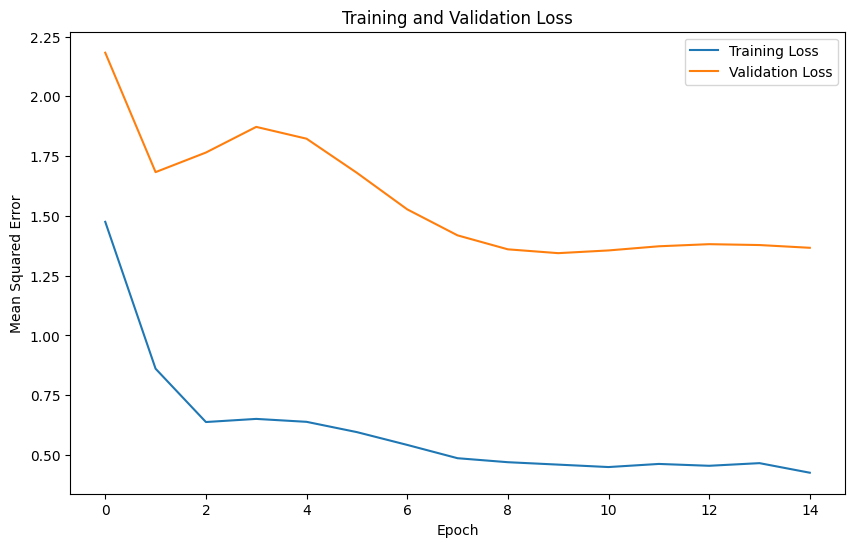

In [ ]:
training_loss = history.history['mean_squared_error']
validation_loss = history.history['val_mean_squared_error']

plt.figure(figsize=(10, 6))
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import r2_score
y_pred_test_sd = model.predict(X_test_sd)
y_pred_un = y_pred_test_sd * np.array(y_std) + np.array(y_mean)

print(y_test.iloc[0])
print(y_pred_un[0])

r_squared = r2_score(y_test, y_pred_un)
print(r_squared)

2/2 [==============================] - 0s 11ms/step
hour_1      376.0
hour_2      171.0
hour_3      116.0
hour_4       62.0
hour_5       93.0
hour_6      315.0
hour_7     1191.0
hour_8     2560.0
hour_9     4848.0
hour_10    3609.0
hour_11    2330.0
hour_12    2190.0
hour_13    2783.0
hour_14    2936.0
hour_15    3192.0
hour_16    3398.0
hour_17    4590.0
hour_18    6068.0
hour_19    4409.0
hour_20    1690.0
hour_21     993.0
hour_22     648.0
hour_23     513.0
hour_24     570.0
Name: 2018-11-02 00:00:00, dtype: float64
[ 330.6849809   185.60107642   77.73838698   24.95119398   92.23348113
  295.64684488 1108.27268067 2426.46291401 3138.42850989 1706.25083622
  516.09699852 1459.06656254 2056.54433123 1935.26059001 2282.53191107
 2266.88182623 2839.85936891 3939.79273707 4159.10381596 2220.17561593
 1565.63617655 1131.96444129 1020.26053476  712.78372576]
-0.11891211143769946


In [ ]:
def multi_output_r2_score(y_true, y_pred):
    n_targets = y_true.shape[1]
    r2_scores = []

    for target in range(n_targets):
        r2 = r2_score(y_true[:, target], y_pred[:, target])
        r2_scores.append(r2)

    return r2_scores

y_pred_test = model.predict(X_test)
r_squared = multi_output_r2_score(y_test.to_numpy(), y_pred_test)
print(r_squared)




In [ ]:
df = pd.read_csv('data_with_clusters.csv', index_col=0,
                 dtype={"tripduration": "int32", "start_station_id" : "category", "start_station_latitude" : "float64",
                        "start_station_longitude": "float64", "end_station_id": "category", "end_station_latitude": "float64",
                        "end_station_longitude": "float64", "bikeid": "category", "usertype": "string", "birth_year": "int64", "gender": "int64"},
                 parse_dates=["starttime", "stoptime"])

In [ ]:
# select only the data belonging to the two clusters with largest demand
# df_two_cluster = df.loc[(df["start_at_cluster"] == 0) | (df["start_at_cluster"] == 1)].copy()
del df


In [ ]:
"""
# Exctracting to what extent a trip took place on a weekday or a weekend and what day of the week
# Extract weekday and weekend
df_two_cluster["weekday"] = df_two_cluster.starttime.dt.weekday
df_two_cluster['weekend'] = df_two_cluster.weekday.isin([5, 6])

days_of_week = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
df_two_cluster.loc[:,'week_day'] = df_two_cluster["weekday"].map(lambda x: days_of_week[x])


def time_of_day(hour):
    h_thresholds = [7, 8, 12, 14, 17, 20, 23]
    h_names = ["night", "morning rush", "morning", "lunch time", "afternoon", "afternoon rush", "evening", "night"]
    return h_names[next((i for i, threshold in enumerate(h_thresholds) if hour <= threshold), -1)]

df_two_cluster['time_of_day'] = df_two_cluster.starttime.dt.hour.map(time_of_day)
"""

In [ ]:
# We now convert some of our data into dummy variables, so that the models we have can use the data
#df_two_cluster_dummies=pd.get_dummies(df_two_cluster, columns=['gender', 'week_day', 'time_of_day'])
#df_two_cluster_dummies.columns

In [ ]:
# select only the data belonging to the two clusters with largest demand
#df_1 = df_two_cluster_dummies[df_two_cluster_dummies["start_at_cluster"] == 0]
#df_2 = df_two_cluster_dummies[df_two_cluster_dummies["start_at_cluster"] == 1]

In [ ]:
#df_1.head()
#df_1.dtypes

In [ ]:
def buildLaggedFeatures(s,columns, lag=2,dropna=True):
    '''
    From http://stackoverflow.com/questions/20410312/how-to-create-a-lagged-data-structure-using-pandas-dataframe
    Builds a new DataFrame to facilitate regressing over all possible lagged features
    '''
    if type(s) is pd.DataFrame:
        new_dict={}
        for c in s.columns:
            new_dict[c]=s[c]
        for col_name in columns:
            new_dict[col_name]=s[col_name]
            # create lagged Series
            for l in range(1,lag+1):
                new_dict['%s_lag%d' %(col_name,l)]=s[col_name].shift(l)
        res=pd.DataFrame(new_dict,index=s.index)

    elif type(s) is pd.Series:
        the_range=range(lag+1)
        res=pd.concat([s.shift(i) for i in the_range],axis=1)
        res.columns=['lag_%d' %i for i in the_range]
    else:
        print('Only works for DataFrame or Series')
        return None
    if dropna:
        return res.dropna()
    else:
        return res

In [ ]:
df_f_1_lagged=buildLaggedFeatures(df_f_1, ['ride_count'], lag=24)

df_f_1_lagged["weekday"] = df_f_1_lagged.datetime.dt.weekday
days_of_week = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
df_f_1_lagged.loc[:,'week_day'] = df_f_1_lagged["weekday"].map(lambda x: days_of_week[x])
df_f_1_lagged['time_of_day'] = df_f_1_lagged.datetime.dt.hour.map(time_of_day)
df_f_1_lagged=pd.get_dummies(df_f_1_lagged, columns=['week_day', 'time_of_day'])
df_f_1_lagged = df_f_1_lagged.set_index("datetime")

nov_dec_mask = (df_f_1_lagged.index.month == 11) | (df_f_1_lagged.index.month == 12)
train_set = df_f_1_lagged[~nov_dec_mask]  # Rows not in November or December
test_set = df_f_1_lagged[nov_dec_mask]

In [ ]:
train_set.shape

In [ ]:
df_f_1_lagged.columns
y=np.array(train_set['ride_count'], ndmin=2).T
df_selected = train_set.drop('ride_count', axis=1)
x=np.c_[np.ones(len(train_set)), df_selected]

y_test = np.array(test_set['ride_count'], ndmin=2).T
df_selected = test_set.drop('ride_count', axis=1)
x_test=np.c_[np.ones(len(test_set)), df_selected]

In [ ]:
x

In [ ]:
from sklearn import datasets, linear_model
from sklearn.metrics import r2_score
regr=linear_model.LinearRegression(fit_intercept=False)
regr.fit(x, y)

From here and down it is not correct and we need to do some changes

In [ ]:
y_pred_test = regr.predict(x_test)
r_squared = r2_score(y_pred_test, y_test)
print(r_squared)

In [ ]:
def prediction_model (model, x_test):
  for i in range(0, 24):
    prediction = model.predict(np.hstack(([1], x_test[i: i + 40])).reshape(1, -1))
    x_test = np.append(x_test, prediction)
  return x_test[24:]

In [ ]:
y_test_finished = y_test[25:25+24]
df_selected = test_set.drop('ride_count', axis=1)
x_test_finished = x_test[0]

predicted_values = prediction_model(regr, x_test_finished)

In [ ]:
r_squared = r2_score(predicted_values, y_test_finished)
print(y_test_finished)
print(predicted_values)
